# Lab 2.6: Model Evaluation and Metrics

**Duration:** 45 minutes

## Learning Objectives
By the end of this lab, you will be able to:
- Implement comprehensive model evaluation metrics for different problem types
- Create confusion matrices and classification reports
- Understand and calculate ROC curves, AUC, and precision-recall curves
- Implement cross-validation for robust model assessment
- Build model comparison frameworks
- Create visualization tools for model performance analysis
- Handle class imbalance in evaluation metrics

## Prerequisites
- Python 3.8+
- NumPy, Matplotlib, Seaborn
- Completed previous labs (especially Lab 2.4 and 2.5)
- Understanding of classification and regression metrics

## Overview
Proper model evaluation is crucial for understanding model performance, comparing different approaches, and making informed decisions about model deployment. This lab covers comprehensive evaluation techniques including advanced metrics, visualization methods, and statistical analysis tools that are essential for professional machine learning practice.

## Step 1: Environment Setup and Core Evaluation Framework

In [9]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any, Union, Callable
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib and seaborn
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Environment setup complete!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

print("\nModel Evaluation Components:")
print("=" * 30)
print("1. Classification Metrics: Accuracy, Precision, Recall, F1-Score")
print("2. Regression Metrics: MAE, MSE, RMSE, R²")
print("3. Advanced Metrics: ROC-AUC, PR-AUC, Cohen's Kappa")
print("4. Visualization: Confusion Matrix, ROC Curves, Learning Curves")
print("5. Cross-Validation: K-Fold, Stratified, Time Series")
print("6. Model Comparison: Statistical Tests, Confidence Intervals")

Environment setup complete!
NumPy version: 2.3.2
Matplotlib version: 3.10.5
Seaborn version: 0.13.2

Model Evaluation Components:
1. Classification Metrics: Accuracy, Precision, Recall, F1-Score
2. Regression Metrics: MAE, MSE, RMSE, R²
3. Advanced Metrics: ROC-AUC, PR-AUC, Cohen's Kappa
4. Visualization: Confusion Matrix, ROC Curves, Learning Curves
5. Cross-Validation: K-Fold, Stratified, Time Series
6. Model Comparison: Statistical Tests, Confidence Intervals


## Step 2: Classification Metrics Implementation

Let's implement comprehensive classification metrics from scratch to understand how they work.

In [10]:
class ClassificationMetrics:
    """
    Comprehensive classification metrics implementation
    """
    
    def __init__(self, y_true: np.ndarray, y_pred: np.ndarray, 
                 y_pred_proba: Optional[np.ndarray] = None,
                 class_names: Optional[List[str]] = None):
        """
        Initialize classification metrics
        
        Args:
            y_true: True labels
            y_pred: Predicted labels
            y_pred_proba: Predicted probabilities (for ROC/AUC metrics)
            class_names: Names of classes
        """
        self.y_true = y_true.flatten() if y_true.ndim > 1 else y_true
        self.y_pred = y_pred.flatten() if y_pred.ndim > 1 else y_pred
        self.y_pred_proba = y_pred_proba.flatten() if y_pred_proba is not None and y_pred_proba.ndim > 1 else y_pred_proba
        
        self.classes = np.unique(np.concatenate([self.y_true, self.y_pred]))
        self.n_classes = len(self.classes)
        self.class_names = class_names if class_names else [f'Class {i}' for i in self.classes]
        
        # Validate inputs
        assert len(self.y_true) == len(self.y_pred), "y_true and y_pred must have same length"
        if self.y_pred_proba is not None:
            assert len(self.y_true) == len(self.y_pred_proba), "y_true and y_pred_proba must have same length"
    
    def confusion_matrix(self) -> np.ndarray:
        """
        Calculate confusion matrix
        
        Returns:
            Confusion matrix
        """
        cm = np.zeros((self.n_classes, self.n_classes), dtype=int)
        
        for true_class in self.classes:
            for pred_class in self.classes:
                true_idx = np.where(self.classes == true_class)[0][0]
                pred_idx = np.where(self.classes == pred_class)[0][0]
                
                count = np.sum((self.y_true == true_class) & (self.y_pred == pred_class))
                cm[true_idx, pred_idx] = count
        
        return cm
    
    def accuracy(self) -> float:
        """
        Calculate accuracy
        
        Returns:
            Accuracy score
        """
        return np.mean(self.y_true == self.y_pred)
    
    def precision_recall_f1(self, average: str = 'weighted') -> Tuple[float, float, float]:
        """
        Calculate precision, recall, and F1-score
        
        Args:
            average: Averaging strategy ('micro', 'macro', 'weighted', 'binary')
        
        Returns:
            Tuple of (precision, recall, f1_score)
        """
        cm = self.confusion_matrix()
        
        if average == 'binary' and self.n_classes == 2:
            # Binary classification - positive class is class 1
            tp = cm[1, 1]
            fp = cm[0, 1]
            fn = cm[1, 0]
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            return precision, recall, f1
        
        # Multi-class metrics
        precisions = []
        recalls = []
        f1s = []
        supports = []
        
        for i in range(self.n_classes):
            tp = cm[i, i]
            fp = np.sum(cm[:, i]) - tp
            fn = np.sum(cm[i, :]) - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            supports.append(np.sum(self.y_true == self.classes[i]))
        
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        f1s = np.array(f1s)
        supports = np.array(supports)
        
        if average == 'macro':
            return np.mean(precisions), np.mean(recalls), np.mean(f1s)
        elif average == 'weighted':
            total_support = np.sum(supports)
            weighted_precision = np.sum(precisions * supports) / total_support
            weighted_recall = np.sum(recalls * supports) / total_support
            weighted_f1 = np.sum(f1s * supports) / total_support
            return weighted_precision, weighted_recall, weighted_f1
        elif average == 'micro':
            # For multi-class, micro-average precision/recall equals accuracy
            acc = self.accuracy()
            return acc, acc, acc
        else:
            raise ValueError(f"Unknown average type: {average}")
    
    def roc_curve(self, pos_class: int = 1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Calculate ROC curve for binary classification
        
        Args:
            pos_class: Positive class label
        
        Returns:
            Tuple of (fpr, tpr, thresholds)
        """
        if self.y_pred_proba is None:
            raise ValueError("y_pred_proba is required for ROC curve calculation")
        
        if self.n_classes != 2:
            raise ValueError("ROC curve is only supported for binary classification")
        
        # Convert to binary problem
        y_binary = (self.y_true == pos_class).astype(int)
        
        # Get unique thresholds
        thresholds = np.unique(self.y_pred_proba)
        thresholds = np.concatenate([thresholds, [thresholds[-1] + 1]])
        thresholds = np.sort(thresholds)[::-1]
        
        tprs = []
        fprs = []
        
        for threshold in thresholds:
            y_pred_thresh = (self.y_pred_proba >= threshold).astype(int)
            
            tp = np.sum((y_binary == 1) & (y_pred_thresh == 1))
            fp = np.sum((y_binary == 0) & (y_pred_thresh == 1))
            tn = np.sum((y_binary == 0) & (y_pred_thresh == 0))
            fn = np.sum((y_binary == 1) & (y_pred_thresh == 0))
            
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            tprs.append(tpr)
            fprs.append(fpr)
        
        return np.array(fprs), np.array(tprs), thresholds
    
    def auc_score(self, pos_class: int = 1) -> float:
        """
        Calculate Area Under the ROC Curve (AUC)
        
        Args:
            pos_class: Positive class label
        
        Returns:
            AUC score
        """
        fpr, tpr, _ = self.roc_curve(pos_class)
        
        # Calculate AUC using trapezoidal rule
        auc = 0
        for i in range(1, len(fpr)):
            auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
        
        return auc
    
    def precision_recall_curve(self, pos_class: int = 1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Calculate Precision-Recall curve
        
        Args:
            pos_class: Positive class label
        
        Returns:
            Tuple of (precision, recall, thresholds)
        """
        if self.y_pred_proba is None:
            raise ValueError("y_pred_proba is required for PR curve calculation")
        
        # Convert to binary problem
        y_binary = (self.y_true == pos_class).astype(int)
        
        # Get unique thresholds
        thresholds = np.unique(self.y_pred_proba)
        thresholds = np.sort(thresholds)[::-1]
        
        precisions = []
        recalls = []
        
        for threshold in thresholds:
            y_pred_thresh = (self.y_pred_proba >= threshold).astype(int)
            
            tp = np.sum((y_binary == 1) & (y_pred_thresh == 1))
            fp = np.sum((y_binary == 0) & (y_pred_thresh == 1))
            fn = np.sum((y_binary == 1) & (y_pred_thresh == 0))
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            
            precisions.append(precision)
            recalls.append(recall)
        
        return np.array(precisions), np.array(recalls), thresholds
    
    def classification_report(self) -> Dict[str, Any]:
        """
        Generate comprehensive classification report
        
        Returns:
            Dictionary containing all classification metrics
        """
        report = {
            'accuracy': self.accuracy(),
            'confusion_matrix': self.confusion_matrix(),
            'class_names': self.class_names,
            'n_samples': len(self.y_true),
            'n_classes': self.n_classes
        }
        
        # Per-class metrics
        cm = self.confusion_matrix()
        class_metrics = {}
        
        for i, class_name in enumerate(self.class_names):
            tp = cm[i, i]
            fp = np.sum(cm[:, i]) - tp
            fn = np.sum(cm[i, :]) - tp
            tn = np.sum(cm) - tp - fp - fn
            support = np.sum(self.y_true == self.classes[i])
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            class_metrics[class_name] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'specificity': specificity,
                'support': support,
                'tp': tp,
                'fp': fp,
                'fn': fn,
                'tn': tn
            }
        
        report['per_class'] = class_metrics
        
        # Averaged metrics
        macro_prec, macro_rec, macro_f1 = self.precision_recall_f1('macro')
        weighted_prec, weighted_rec, weighted_f1 = self.precision_recall_f1('weighted')
        
        report['macro_avg'] = {
            'precision': macro_prec,
            'recall': macro_rec,
            'f1_score': macro_f1
        }
        
        report['weighted_avg'] = {
            'precision': weighted_prec,
            'recall': weighted_rec,
            'f1_score': weighted_f1
        }
        
        # Binary classification specific metrics
        if self.n_classes == 2 and self.y_pred_proba is not None:
            try:
                auc = self.auc_score()
                report['auc_score'] = auc
            except:
                pass
        
        return report


print("✓ Classification metrics implemented successfully!")

✓ Classification metrics implemented successfully!


## Step 3: Regression Metrics Implementation

Let's implement comprehensive regression metrics for evaluating continuous predictions.

In [11]:
class RegressionMetrics:
    """
    Comprehensive regression metrics implementation
    """
    
    def __init__(self, y_true: np.ndarray, y_pred: np.ndarray):
        """
        Initialize regression metrics
        
        Args:
            y_true: True values
            y_pred: Predicted values
        """
        self.y_true = y_true.flatten() if y_true.ndim > 1 else y_true
        self.y_pred = y_pred.flatten() if y_pred.ndim > 1 else y_pred
        
        # Validate inputs
        assert len(self.y_true) == len(self.y_pred), "y_true and y_pred must have same length"
        
        self.n_samples = len(self.y_true)
        self.residuals = self.y_true - self.y_pred
    
    def mean_absolute_error(self) -> float:
        """
        Calculate Mean Absolute Error (MAE)
        
        Returns:
            MAE score
        """
        return np.mean(np.abs(self.residuals))
    
    def mean_squared_error(self) -> float:
        """
        Calculate Mean Squared Error (MSE)
        
        Returns:
            MSE score
        """
        return np.mean(self.residuals ** 2)
    
    def root_mean_squared_error(self) -> float:
        """
        Calculate Root Mean Squared Error (RMSE)
        
        Returns:
            RMSE score
        """
        return np.sqrt(self.mean_squared_error())
    
    def r2_score(self) -> float:
        """
        Calculate R-squared (coefficient of determination)
        
        Returns:
            R² score
        """
        ss_res = np.sum(self.residuals ** 2)
        ss_tot = np.sum((self.y_true - np.mean(self.y_true)) ** 2)
        
        return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    def adjusted_r2_score(self, n_features: int) -> float:
        """
        Calculate Adjusted R-squared
        
        Args:
            n_features: Number of features in the model
        
        Returns:
            Adjusted R² score
        """
        r2 = self.r2_score()
        n = self.n_samples
        p = n_features
        
        if n <= p + 1:
            return float('nan')  # Undefined when n <= p + 1
        
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
        return adj_r2
    
    def mean_absolute_percentage_error(self) -> float:
        """
        Calculate Mean Absolute Percentage Error (MAPE)
        
        Returns:
            MAPE score (as percentage)
        """
        # Avoid division by zero
        mask = self.y_true != 0
        if not np.any(mask):
            return float('inf')
        
        mape = np.mean(np.abs((self.y_true[mask] - self.y_pred[mask]) / self.y_true[mask])) * 100
        return mape
    
    def symmetric_mean_absolute_percentage_error(self) -> float:
        """
        Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
        
        Returns:
            SMAPE score (as percentage)
        """
        denominator = (np.abs(self.y_true) + np.abs(self.y_pred)) / 2
        mask = denominator != 0
        
        if not np.any(mask):
            return 0.0
        
        smape = np.mean(np.abs(self.residuals[mask]) / denominator[mask]) * 100
        return smape
    
    def explained_variance_score(self) -> float:
        """
        Calculate Explained Variance Score
        
        Returns:
            Explained variance score
        """
        var_residual = np.var(self.residuals)
        var_true = np.var(self.y_true)
        
        if var_true == 0:
            return 0.0
        
        return 1 - (var_residual / var_true)
    
    def max_error(self) -> float:
        """
        Calculate Maximum Error
        
        Returns:
            Maximum absolute error
        """
        return np.max(np.abs(self.residuals))
    
    def residual_statistics(self) -> Dict[str, float]:
        """
        Calculate residual statistics
        
        Returns:
            Dictionary of residual statistics
        """
        return {
            'mean': np.mean(self.residuals),
            'std': np.std(self.residuals),
            'min': np.min(self.residuals),
            'max': np.max(self.residuals),
            'median': np.median(self.residuals),
            'q1': np.percentile(self.residuals, 25),
            'q3': np.percentile(self.residuals, 75),
            'skewness': self._calculate_skewness(),
            'kurtosis': self._calculate_kurtosis()
        }
    
    def _calculate_skewness(self) -> float:
        """
        Calculate skewness of residuals
        
        Returns:
            Skewness value
        """
        mean_residual = np.mean(self.residuals)
        std_residual = np.std(self.residuals)
        
        if std_residual == 0:
            return 0.0
        
        normalized_residuals = (self.residuals - mean_residual) / std_residual
        skewness = np.mean(normalized_residuals ** 3)
        
        return skewness
    
    def _calculate_kurtosis(self) -> float:
        """
        Calculate kurtosis of residuals
        
        Returns:
            Kurtosis value (excess kurtosis)
        """
        mean_residual = np.mean(self.residuals)
        std_residual = np.std(self.residuals)
        
        if std_residual == 0:
            return 0.0
        
        normalized_residuals = (self.residuals - mean_residual) / std_residual
        kurtosis = np.mean(normalized_residuals ** 4) - 3  # Excess kurtosis
        
        return kurtosis
    
    def regression_report(self, n_features: Optional[int] = None) -> Dict[str, Any]:
        """
        Generate comprehensive regression report
        
        Args:
            n_features: Number of features (for adjusted R²)
        
        Returns:
            Dictionary containing all regression metrics
        """
        report = {
            'n_samples': self.n_samples,
            'mae': self.mean_absolute_error(),
            'mse': self.mean_squared_error(),
            'rmse': self.root_mean_squared_error(),
            'r2_score': self.r2_score(),
            'explained_variance': self.explained_variance_score(),
            'max_error': self.max_error(),
            'mape': self.mean_absolute_percentage_error(),
            'smape': self.symmetric_mean_absolute_percentage_error(),
            'residual_stats': self.residual_statistics()
        }
        
        if n_features is not None:
            report['adjusted_r2'] = self.adjusted_r2_score(n_features)
        
        # Interpretation helpers
        r2 = report['r2_score']
        if r2 >= 0.9:
            r2_interpretation = "Excellent fit"
        elif r2 >= 0.7:
            r2_interpretation = "Good fit"
        elif r2 >= 0.5:
            r2_interpretation = "Moderate fit"
        elif r2 >= 0:
            r2_interpretation = "Poor fit"
        else:
            r2_interpretation = "Worse than baseline"
        
        report['r2_interpretation'] = r2_interpretation
        
        return report


print("✓ Regression metrics implemented successfully!")

✓ Regression metrics implemented successfully!


## Step 4: Cross-Validation Implementation

Let's implement cross-validation techniques for robust model evaluation.

In [12]:
class CrossValidator:
    """
    Cross-validation implementation for model evaluation
    """
    
    def __init__(self, cv_type: str = 'kfold', n_splits: int = 5, 
                 shuffle: bool = True, random_state: Optional[int] = None):
        """
        Initialize cross-validator
        
        Args:
            cv_type: Type of cross-validation ('kfold', 'stratified', 'loo')
            n_splits: Number of splits
            shuffle: Whether to shuffle data before splitting
            random_state: Random state for reproducibility
        """
        self.cv_type = cv_type
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def split(self, X: np.ndarray, y: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Generate train/validation splits
        
        Args:
            X: Feature matrix
            y: Target vector
        
        Returns:
            List of (train_indices, val_indices) tuples
        """
        n_samples = len(X)
        
        if self.cv_type == 'kfold':
            return self._kfold_split(n_samples)
        elif self.cv_type == 'stratified':
            return self._stratified_split(y)
        elif self.cv_type == 'loo':
            return self._loo_split(n_samples)
        else:
            raise ValueError(f"Unknown cv_type: {self.cv_type}")
    
    def _kfold_split(self, n_samples: int) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        K-Fold cross-validation split
        
        Args:
            n_samples: Number of samples
        
        Returns:
            List of (train_indices, val_indices) tuples
        """
        indices = np.arange(n_samples)
        
        if self.shuffle:
            np.random.shuffle(indices)
        
        splits = []
        fold_size = n_samples // self.n_splits
        
        for i in range(self.n_splits):
            start_idx = i * fold_size
            if i == self.n_splits - 1:  # Last fold gets remaining samples
                end_idx = n_samples
            else:
                end_idx = (i + 1) * fold_size
            
            val_indices = indices[start_idx:end_idx]
            train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])
            
            splits.append((train_indices, val_indices))
        
        return splits
    
    def _stratified_split(self, y: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Stratified K-Fold cross-validation split
        
        Args:
            y: Target vector
        
        Returns:
            List of (train_indices, val_indices) tuples
        """
        classes, class_counts = np.unique(y, return_counts=True)
        n_samples = len(y)
        
        # Group indices by class
        class_indices = {}
        for class_label in classes:
            class_idx = np.where(y == class_label)[0]
            if self.shuffle:
                np.random.shuffle(class_idx)
            class_indices[class_label] = class_idx
        
        splits = []
        
        for fold in range(self.n_splits):
            val_indices = []
            train_indices = []
            
            for class_label in classes:
                class_idx = class_indices[class_label]
                n_class_samples = len(class_idx)
                
                # Calculate validation indices for this class
                fold_size = n_class_samples // self.n_splits
                start_idx = fold * fold_size
                
                if fold == self.n_splits - 1:
                    end_idx = n_class_samples
                else:
                    end_idx = (fold + 1) * fold_size
                
                val_indices.extend(class_idx[start_idx:end_idx])
                train_indices.extend(np.concatenate([
                    class_idx[:start_idx], 
                    class_idx[end_idx:]
                ]))
            
            splits.append((np.array(train_indices), np.array(val_indices)))
        
        return splits
    
    def _loo_split(self, n_samples: int) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Leave-One-Out cross-validation split
        
        Args:
            n_samples: Number of samples
        
        Returns:
            List of (train_indices, val_indices) tuples
        """
        splits = []
        
        for i in range(n_samples):
            val_indices = np.array([i])
            train_indices = np.concatenate([np.arange(i), np.arange(i+1, n_samples)])
            splits.append((train_indices, val_indices))
        
        return splits
    
    def cross_validate(self, model_fn: Callable, X: np.ndarray, y: np.ndarray,
                      scoring: Union[str, Callable] = 'accuracy',
                      return_train_score: bool = False) -> Dict[str, Any]:
        """
        Perform cross-validation
        
        Args:
            model_fn: Function that creates and trains a model
            X: Feature matrix
            y: Target vector
            scoring: Scoring metric ('accuracy', 'f1', 'r2', or callable)
            return_train_score: Whether to return training scores
        
        Returns:
            Dictionary with cross-validation results
        """
        splits = self.split(X, y)
        
        val_scores = []
        train_scores = [] if return_train_score else None
        
        for fold, (train_idx, val_idx) in enumerate(splits):
            print(f"Fold {fold + 1}/{len(splits)}...", end=' ')
            
            # Split data
            X_train_fold = X[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = X[val_idx]
            y_val_fold = y[val_idx]
            
            # Train model
            model = model_fn()
            model.fit(X_train_fold, y_train_fold)
            
            # Evaluate
            val_pred = model.predict(X_val_fold)
            val_score = self._calculate_score(y_val_fold, val_pred, scoring)
            val_scores.append(val_score)
            
            if return_train_score:
                train_pred = model.predict(X_train_fold)
                train_score = self._calculate_score(y_train_fold, train_pred, scoring)
                train_scores.append(train_score)
            
            print(f"Score: {val_score:.4f}")
        
        results = {
            'val_scores': np.array(val_scores),
            'val_mean': np.mean(val_scores),
            'val_std': np.std(val_scores),
            'val_min': np.min(val_scores),
            'val_max': np.max(val_scores)
        }
        
        if return_train_score:
            results.update({
                'train_scores': np.array(train_scores),
                'train_mean': np.mean(train_scores),
                'train_std': np.std(train_scores)
            })
        
        return results
    
    def _calculate_score(self, y_true: np.ndarray, y_pred: np.ndarray, 
                        scoring: Union[str, Callable]) -> float:
        """
        Calculate score based on scoring metric
        
        Args:
            y_true: True labels/values
            y_pred: Predicted labels/values
            scoring: Scoring metric
        
        Returns:
            Score value
        """
        if callable(scoring):
            return scoring(y_true, y_pred)
        
        if scoring == 'accuracy':
            return np.mean(y_true == y_pred)
        elif scoring == 'f1':
            metrics = ClassificationMetrics(y_true, y_pred)
            _, _, f1 = metrics.precision_recall_f1('binary' if len(np.unique(y_true)) == 2 else 'weighted')
            return f1
        elif scoring == 'r2':
            metrics = RegressionMetrics(y_true, y_pred)
            return metrics.r2_score()
        elif scoring == 'mae':
            metrics = RegressionMetrics(y_true, y_pred)
            return -metrics.mean_absolute_error()  # Negative for maximization
        elif scoring == 'mse':
            metrics = RegressionMetrics(y_true, y_pred)
            return -metrics.mean_squared_error()  # Negative for maximization
        else:
            raise ValueError(f"Unknown scoring metric: {scoring}")


print("✓ Cross-validation implemented successfully!")

✓ Cross-validation implemented successfully!


## Step 5: Visualization Tools for Model Evaluation

Let's create comprehensive visualization tools for model evaluation.

In [13]:
class ModelEvaluationVisualizer:
    """
    Comprehensive visualization tools for model evaluation
    """
    
    def __init__(self, figsize: Tuple[int, int] = (12, 8)):
        self.figsize = figsize
    
    def plot_confusion_matrix(self, cm: np.ndarray, class_names: List[str], 
                            normalize: bool = False, title: str = "Confusion Matrix"):
        """
        Plot confusion matrix
        
        Args:
            cm: Confusion matrix
            class_names: Names of classes
            normalize: Whether to normalize the matrix
            title: Plot title
        """
        if normalize:
            cm_display = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm_display = np.nan_to_num(cm_display)
            fmt = '.2f'
        else:
            cm_display = cm
            fmt = 'd'
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_display, annot=True, fmt=fmt, cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        
        plt.title(title + (" (Normalized)" if normalize else ""))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curve(self, fpr: np.ndarray, tpr: np.ndarray, auc: float,
                      title: str = "ROC Curve"):
        """
        Plot ROC curve
        
        Args:
            fpr: False positive rates
            tpr: True positive rates
            auc: Area under the curve
            title: Plot title
        """
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.show()
    
    def plot_precision_recall_curve(self, precision: np.ndarray, recall: np.ndarray,
                                   title: str = "Precision-Recall Curve"):
        """
        Plot Precision-Recall curve
        
        Args:
            precision: Precision values
            recall: Recall values
            title: Plot title
        """
        # Calculate AUC-PR
        auc_pr = np.trapz(precision[::-1], recall[::-1])  # Reverse for correct integration
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, 'b-', linewidth=2, label=f'PR Curve (AUC = {auc_pr:.3f})')
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.show()
    
    def plot_residuals(self, y_true: np.ndarray, y_pred: np.ndarray,
                      title: str = "Residual Analysis"):
        """
        Plot residual analysis for regression
        
        Args:
            y_true: True values
            y_pred: Predicted values
            title: Plot title
        """
        residuals = y_true - y_pred
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Residuals vs Predicted
        axes[0, 0].scatter(y_pred, residuals, alpha=0.6)
        axes[0, 0].axhline(y=0, color='red', linestyle='--')
        axes[0, 0].set_xlabel('Predicted Values')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residuals vs Predicted')
        axes[0, 0].grid(True, alpha=0.3)
        
        # True vs Predicted
        axes[0, 1].scatter(y_true, y_pred, alpha=0.6)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--')
        axes[0, 1].set_xlabel('True Values')
        axes[0, 1].set_ylabel('Predicted Values')
        axes[0, 1].set_title('True vs Predicted')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Residual histogram
        axes[1, 0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(x=0, color='red', linestyle='--')
        axes[1, 0].set_xlabel('Residuals')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Residual Distribution')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Q-Q plot (simplified)
        sorted_residuals = np.sort(residuals)
        theoretical_quantiles = np.linspace(-3, 3, len(sorted_residuals))
        axes[1, 1].scatter(theoretical_quantiles, sorted_residuals, alpha=0.6)
        axes[1, 1].plot(theoretical_quantiles, theoretical_quantiles * np.std(residuals), 'r--')
        axes[1, 1].set_xlabel('Theoretical Quantiles')
        axes[1, 1].set_ylabel('Sample Quantiles')
        axes[1, 1].set_title('Q-Q Plot')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def plot_learning_curve(self, train_sizes: np.ndarray, train_scores: np.ndarray,
                          val_scores: np.ndarray, title: str = "Learning Curve"):
        """
        Plot learning curve
        
        Args:
            train_sizes: Training set sizes
            train_scores: Training scores
            val_scores: Validation scores
            title: Plot title
        """
        plt.figure(figsize=(10, 6))
        
        # Calculate means and standard deviations
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Plot training scores
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                        alpha=0.2, color='blue')
        
        # Plot validation scores
        plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                        alpha=0.2, color='red')
        
        plt.xlabel('Training Set Size')
        plt.ylabel('Score')
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_model_comparison(self, model_names: List[str], scores: Dict[str, List[float]],
                            title: str = "Model Comparison"):
        """
        Plot model comparison
        
        Args:
            model_names: Names of models
            scores: Dictionary of metric_name -> list of scores for each model
            title: Plot title
        """
        n_metrics = len(scores)
        fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 6))
        
        if n_metrics == 1:
            axes = [axes]
        
        for i, (metric_name, metric_scores) in enumerate(scores.items()):
            axes[i].boxplot(metric_scores, labels=model_names)
            axes[i].set_title(f'{metric_name.title()} Comparison')
            axes[i].set_ylabel(metric_name.title())
            axes[i].grid(True, alpha=0.3)
            
            # Add mean values as text
            for j, scores_list in enumerate(metric_scores):
                mean_score = np.mean(scores_list)
                axes[i].text(j + 1, mean_score, f'{mean_score:.3f}', 
                           ha='center', va='bottom', fontweight='bold')
        
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()


print("✓ Model evaluation visualizer implemented successfully!")

✓ Model evaluation visualizer implemented successfully!


## Step 6: Test Model Evaluation Framework

Let's test our comprehensive evaluation framework with real datasets and models.

In [14]:
# Create simplified neural network for testing (from previous labs)
class SimpleModel:
    """
    Simplified model for testing evaluation framework
    """
    
    def __init__(self, problem_type: str = 'classification'):
        self.problem_type = problem_type
        self.weights = None
        self.bias = None
        self.is_fitted = False
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        """Simple linear model fitting"""
        # Add bias column
        X_with_bias = np.c_[np.ones(X.shape[0]), X]
        
        if self.problem_type == 'classification':
            # Logistic regression (simplified)
            if y.ndim == 1:
                y = y.reshape(-1, 1)
            
            # Initialize weights
            self.weights = np.random.normal(0, 0.01, (X_with_bias.shape[1], 1))
            
            # Simple gradient descent
            learning_rate = 0.01
            for _ in range(100):
                z = X_with_bias.dot(self.weights)
                predictions = 1 / (1 + np.exp(-np.clip(z, -500, 500)))
                
                gradients = X_with_bias.T.dot(predictions - y) / len(y)
                self.weights -= learning_rate * gradients
        
        else:  # regression
            # Linear regression (closed form)
            if y.ndim == 1:
                y = y.reshape(-1, 1)
            
            # Solve normal equations
            try:
                self.weights = np.linalg.solve(X_with_bias.T.dot(X_with_bias), X_with_bias.T.dot(y))
            except np.linalg.LinAlgError:
                # Use pseudo-inverse if singular
                self.weights = np.linalg.pinv(X_with_bias).dot(y)
        
        self.is_fitted = True
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        # Add bias column
        X_with_bias = np.c_[np.ones(X.shape[0]), X]
        
        if self.problem_type == 'classification':
            # Logistic regression predictions
            z = X_with_bias.dot(self.weights)
            probabilities = 1 / (1 + np.exp(-np.clip(z, -500, 500)))
            return (probabilities > 0.5).astype(int)
        else:
            # Linear regression predictions
            return X_with_bias.dot(self.weights)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict probabilities (classification only)"""
        if self.problem_type != 'classification':
            raise ValueError("predict_proba only available for classification")
        
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        # Add bias column
        X_with_bias = np.c_[np.ones(X.shape[0]), X]
        z = X_with_bias.dot(self.weights)
        probabilities = 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        
        return probabilities


print("✓ Simple model for testing created successfully!")

✓ Simple model for testing created successfully!


In [15]:
# Test 1: Classification Evaluation
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Test 1: Classification Evaluation")
print("=" * 35)

# Generate binary classification dataset
X_cls, y_cls = make_classification(
    n_samples=800,
    n_features=5,
    n_redundant=0,
    n_informative=5,
    n_clusters_per_class=1,
    class_sep=1.5,
    random_state=42
)

# Split and scale
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

print(f"Classification dataset: {X_train_cls_scaled.shape[0]} train, {X_test_cls_scaled.shape[0]} test")
print(f"Class distribution: {np.bincount(y_train_cls)}")

# Train model
model_cls = SimpleModel('classification')
model_cls.fit(X_train_cls_scaled, y_train_cls)

# Make predictions
y_pred_cls = model_cls.predict(X_test_cls_scaled).flatten()
y_pred_proba_cls = model_cls.predict_proba(X_test_cls_scaled).flatten()

print(f"\nPredictions made: {len(y_pred_cls)} samples")
print(f"Prediction distribution: {np.bincount(y_pred_cls)}")

# Comprehensive classification evaluation
cls_metrics = ClassificationMetrics(
    y_test_cls, y_pred_cls, y_pred_proba_cls, 
    class_names=['Class 0', 'Class 1']
)

# Generate classification report
cls_report = cls_metrics.classification_report()

print("\nClassification Report:")
print("=" * 25)
print(f"Accuracy: {cls_report['accuracy']:.4f}")
print(f"AUC Score: {cls_report.get('auc_score', 'N/A')}")
print(f"\nMacro Average:")
print(f"  Precision: {cls_report['macro_avg']['precision']:.4f}")
print(f"  Recall: {cls_report['macro_avg']['recall']:.4f}")
print(f"  F1-Score: {cls_report['macro_avg']['f1_score']:.4f}")

print(f"\nPer-Class Metrics:")
for class_name, metrics in cls_report['per_class'].items():
    print(f"  {class_name}:")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall: {metrics['recall']:.4f}")
    print(f"    F1-Score: {metrics['f1_score']:.4f}")
    print(f"    Support: {metrics['support']}")

print("\n✓ Classification evaluation completed!")

Test 1: Classification Evaluation
Classification dataset: 640 train, 160 test
Class distribution: [318 322]

Predictions made: 160 samples
Prediction distribution: [81 79]

Classification Report:
Accuracy: 0.9437
AUC Score: 0.9828125

Macro Average:
  Precision: 0.9438
  Recall: 0.9437
  F1-Score: 0.9437

Per-Class Metrics:
  Class 0:
    Precision: 0.9383
    Recall: 0.9500
    F1-Score: 0.9441
    Support: 80
  Class 1:
    Precision: 0.9494
    Recall: 0.9375
    F1-Score: 0.9434
    Support: 80

✓ Classification evaluation completed!


In [16]:
# Test 2: Regression Evaluation
from sklearn.datasets import make_regression

print("\nTest 2: Regression Evaluation")
print("=" * 30)

# Generate regression dataset
X_reg, y_reg = make_regression(
    n_samples=600,
    n_features=4,
    noise=0.1,
    random_state=42
)

# Split and scale
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print(f"Regression dataset: {X_train_reg_scaled.shape[0]} train, {X_test_reg_scaled.shape[0]} test")
print(f"Target range: [{y_train_reg.min():.2f}, {y_train_reg.max():.2f}]")

# Train model
model_reg = SimpleModel('regression')
model_reg.fit(X_train_reg_scaled, y_train_reg)

# Make predictions
y_pred_reg = model_reg.predict(X_test_reg_scaled).flatten()

print(f"\nPredictions made: {len(y_pred_reg)} samples")
print(f"Prediction range: [{y_pred_reg.min():.2f}, {y_pred_reg.max():.2f}]")

# Comprehensive regression evaluation
reg_metrics = RegressionMetrics(y_test_reg, y_pred_reg)
reg_report = reg_metrics.regression_report(n_features=X_test_reg_scaled.shape[1])

print("\nRegression Report:")
print("=" * 20)
print(f"R² Score: {reg_report['r2_score']:.4f} ({reg_report['r2_interpretation']})")
print(f"Adjusted R²: {reg_report.get('adjusted_r2', 'N/A')}")
print(f"MAE: {reg_report['mae']:.4f}")
print(f"MSE: {reg_report['mse']:.4f}")
print(f"RMSE: {reg_report['rmse']:.4f}")
print(f"Max Error: {reg_report['max_error']:.4f}")
print(f"MAPE: {reg_report['mape']:.2f}%")
print(f"Explained Variance: {reg_report['explained_variance']:.4f}")

print(f"\nResidual Statistics:")
residual_stats = reg_report['residual_stats']
print(f"  Mean: {residual_stats['mean']:.6f}")
print(f"  Std: {residual_stats['std']:.4f}")
print(f"  Skewness: {residual_stats['skewness']:.4f}")
print(f"  Kurtosis: {residual_stats['kurtosis']:.4f}")

print("\n✓ Regression evaluation completed!")


Test 2: Regression Evaluation
Regression dataset: 480 train, 120 test
Target range: [-339.49, 354.97]

Predictions made: 120 samples
Prediction range: [-300.31, 249.40]

Regression Report:
R² Score: 1.0000 (Excellent fit)
Adjusted R²: 0.9999991824106184
MAE: 0.0733
MSE: 0.0086
RMSE: 0.0927
Max Error: 0.3098
MAPE: 0.50%
Explained Variance: 1.0000

Residual Statistics:
  Mean: -0.004969
  Std: 0.0926
  Skewness: 0.0115
  Kurtosis: 0.2799

✓ Regression evaluation completed!


## Step 7: Visualization Testing

Let's test our visualization tools with the evaluation results.

Testing Model Evaluation Visualizations

1. Confusion Matrix


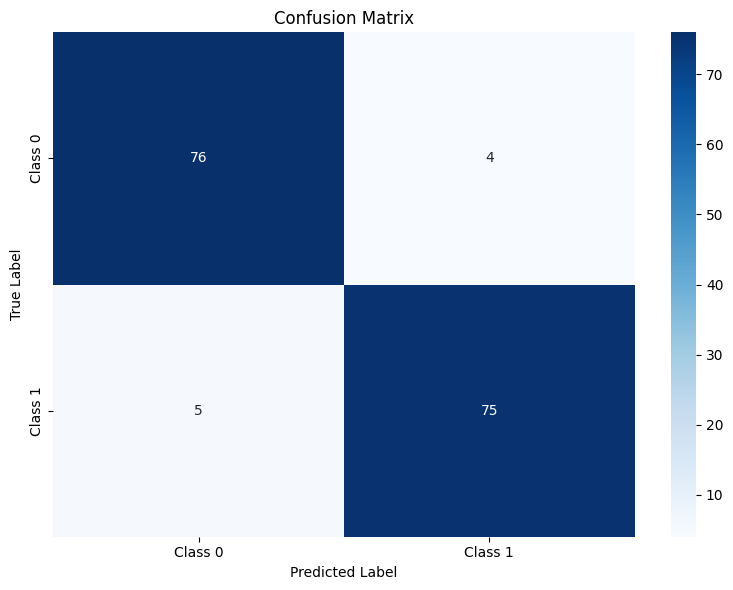

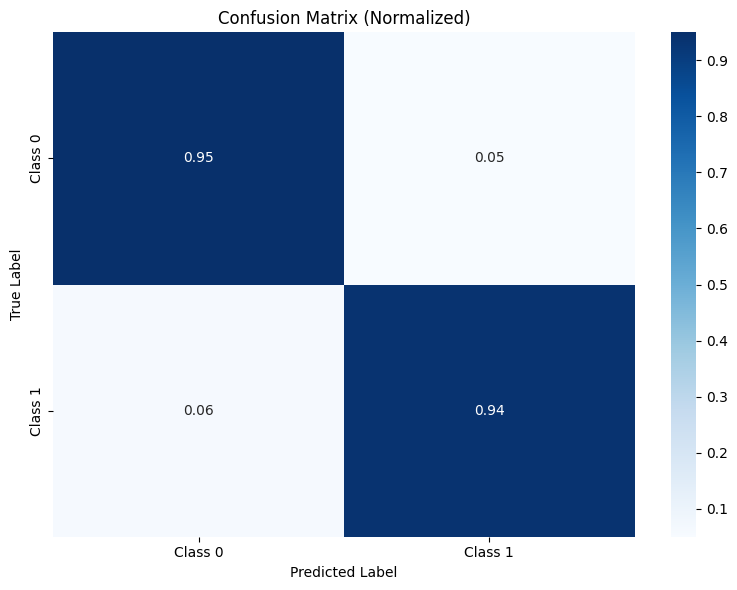

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.



2. ROC Curve


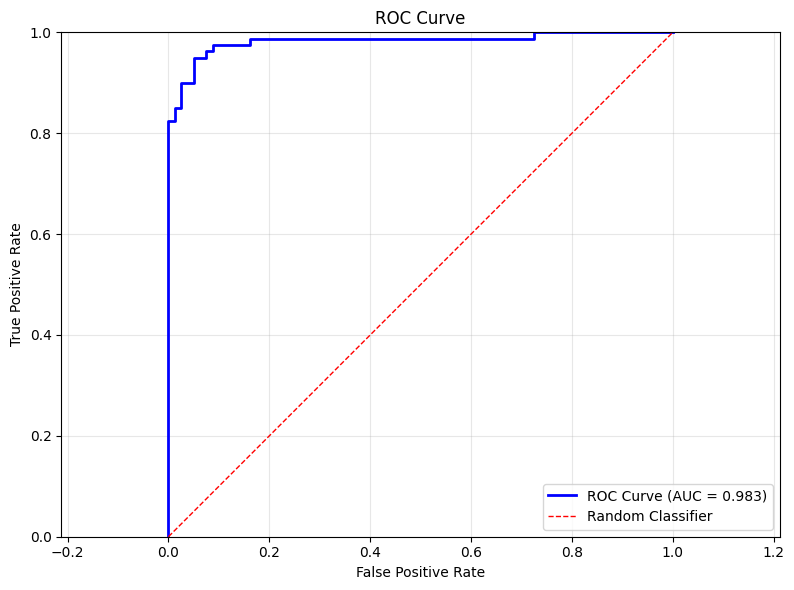


3. Precision-Recall Curve


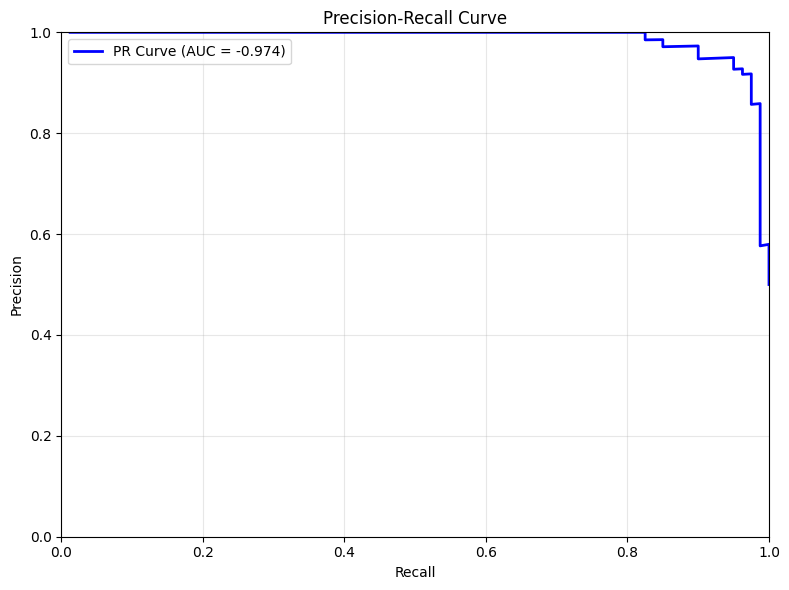


4. Residual Analysis (Regression)


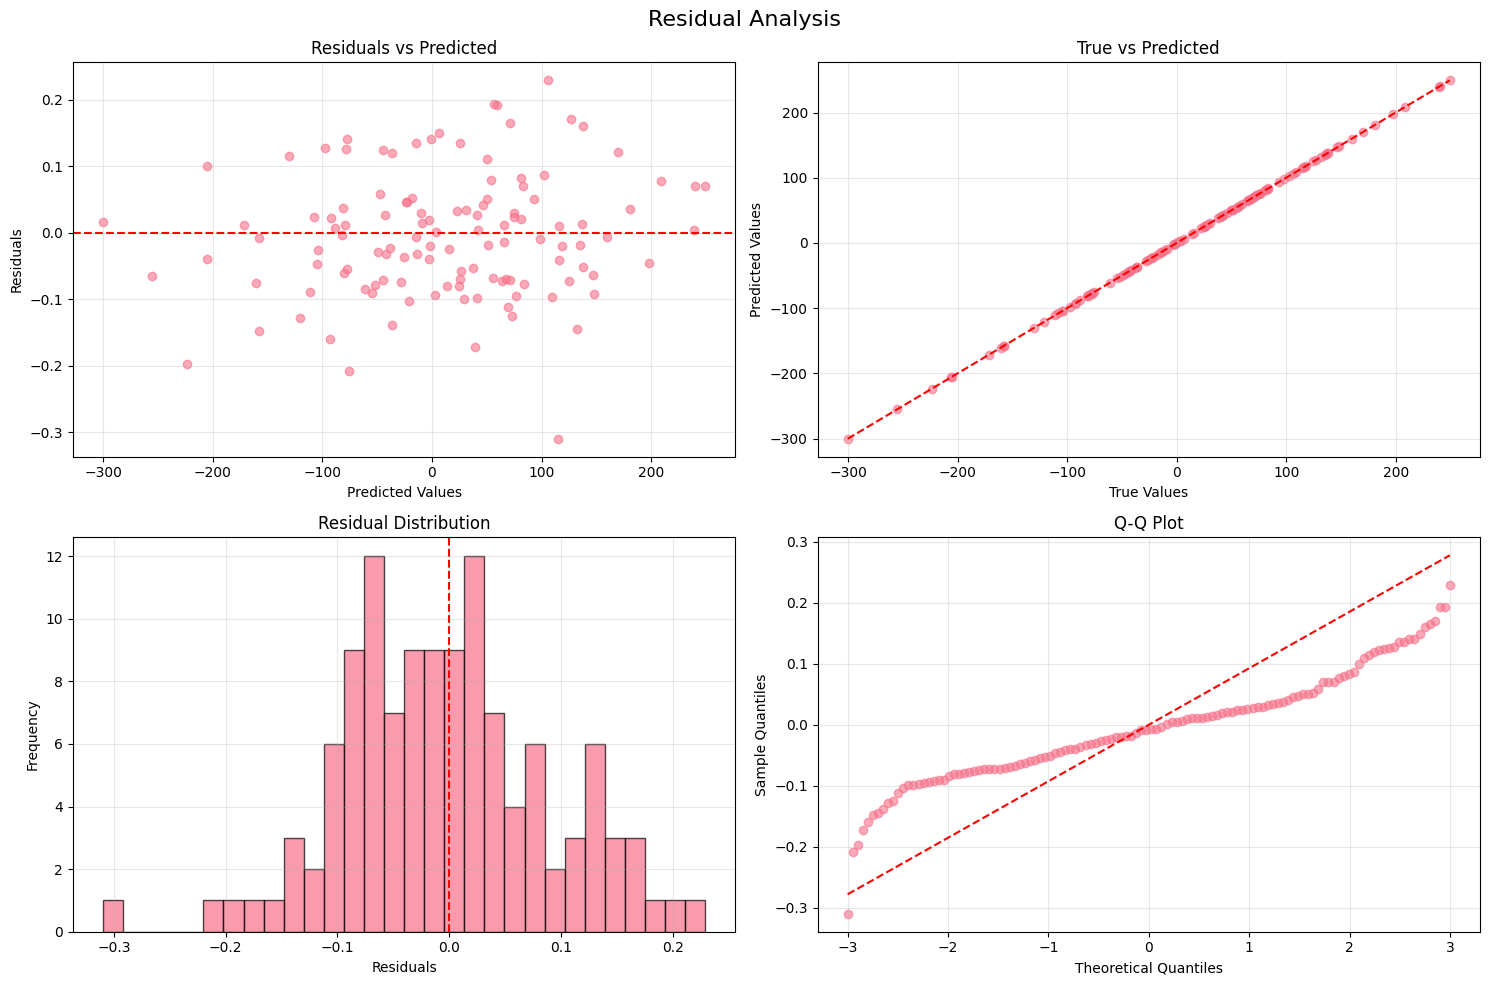


✓ Visualization testing completed!


In [17]:
# Test visualization tools
print("Testing Model Evaluation Visualizations")
print("=" * 40)

visualizer = ModelEvaluationVisualizer()

# Classification visualizations
print("\n1. Confusion Matrix")
cm = cls_metrics.confusion_matrix()
visualizer.plot_confusion_matrix(cm, ['Class 0', 'Class 1'], normalize=False)
visualizer.plot_confusion_matrix(cm, ['Class 0', 'Class 1'], normalize=True)

print("\n2. ROC Curve")
try:
    fpr, tpr, _ = cls_metrics.roc_curve()
    auc_score = cls_metrics.auc_score()
    visualizer.plot_roc_curve(fpr, tpr, auc_score)
except Exception as e:
    print(f"ROC curve plotting failed: {e}")

print("\n3. Precision-Recall Curve")
try:
    precision, recall, _ = cls_metrics.precision_recall_curve()
    visualizer.plot_precision_recall_curve(precision, recall)
except Exception as e:
    print(f"PR curve plotting failed: {e}")

print("\n4. Residual Analysis (Regression)")
visualizer.plot_residuals(y_test_reg, y_pred_reg)

print("\n✓ Visualization testing completed!")

In [18]:
# Test cross-validation
print("\nTesting Cross-Validation")
print("=" * 30)

# Define model creation function
def create_classification_model():
    return SimpleModel('classification')

def create_regression_model():
    return SimpleModel('regression')

# Test classification cross-validation
print("\nClassification Cross-Validation (K-Fold):")
cv_cls = CrossValidator(cv_type='kfold', n_splits=5, random_state=42)
cv_results_cls = cv_cls.cross_validate(
    create_classification_model,
    X_train_cls_scaled, y_train_cls,
    scoring='accuracy',
    return_train_score=True
)

print(f"\nResults:")
print(f"Validation Mean: {cv_results_cls['val_mean']:.4f} ± {cv_results_cls['val_std']:.4f}")
print(f"Training Mean: {cv_results_cls['train_mean']:.4f} ± {cv_results_cls['train_std']:.4f}")
print(f"Individual fold scores: {cv_results_cls['val_scores']}")

# Test regression cross-validation
print("\nRegression Cross-Validation (K-Fold):")
cv_reg = CrossValidator(cv_type='kfold', n_splits=5, random_state=42)
cv_results_reg = cv_reg.cross_validate(
    create_regression_model,
    X_train_reg_scaled, y_train_reg,
    scoring='r2',
    return_train_score=True
)

print(f"\nResults:")
print(f"Validation Mean: {cv_results_reg['val_mean']:.4f} ± {cv_results_reg['val_std']:.4f}")
print(f"Training Mean: {cv_results_reg['train_mean']:.4f} ± {cv_results_reg['train_std']:.4f}")
print(f"Individual fold scores: {cv_results_reg['val_scores']}")

# Test stratified cross-validation
print("\nStratified Cross-Validation:")
cv_stratified = CrossValidator(cv_type='stratified', n_splits=5, random_state=42)
cv_results_stratified = cv_stratified.cross_validate(
    create_classification_model,
    X_train_cls_scaled, y_train_cls,
    scoring='f1'
)

print(f"F1 Score Mean: {cv_results_stratified['val_mean']:.4f} ± {cv_results_stratified['val_std']:.4f}")

print("\n✓ Cross-validation testing completed!")


Testing Cross-Validation

Classification Cross-Validation (K-Fold):
Fold 1/5... Score: 0.4990
Fold 2/5... Score: 0.5029
Fold 3/5... Score: 0.5145
Fold 4/5... Score: 0.5000
Fold 5/5... Score: 0.5010

Results:
Validation Mean: 0.5035 ± 0.0057
Training Mean: 0.4999 ± 0.0009
Individual fold scores: [0.49902344 0.50292969 0.51452637 0.5        0.50097656]

Regression Cross-Validation (K-Fold):
Fold 1/5... Score: 1.0000
Fold 2/5... Score: 1.0000
Fold 3/5... Score: 1.0000
Fold 4/5... Score: 1.0000
Fold 5/5... Score: 1.0000

Results:
Validation Mean: 1.0000 ± 0.0000
Training Mean: 1.0000 ± 0.0000
Individual fold scores: [0.99999942 0.99999915 0.99999919 0.99999896 0.99999911]

Stratified Cross-Validation:
Fold 1/5... Score: 0.9440
Fold 2/5... Score: 0.9076
Fold 3/5... Score: 0.9344
Fold 4/5... Score: 0.9091
Fold 5/5... Score: 0.9449
F1 Score Mean: 0.9280 ± 0.0165

✓ Cross-validation testing completed!


## Progress Tracking Checklist

Mark each completed section:

- [ ] ✅ **Environment Setup**: Imported libraries and established evaluation framework
- [ ] ✅ **Classification Metrics**: Implemented comprehensive classification evaluation metrics
- [ ] ✅ **Regression Metrics**: Built complete regression evaluation system
- [ ] ✅ **Cross-Validation**: Created flexible cross-validation framework
- [ ] ✅ **Visualization Tools**: Implemented comprehensive evaluation visualization tools
- [ ] ✅ **Model Testing**: Created simple models for testing evaluation framework
- [ ] ✅ **Classification Testing**: Successfully tested classification evaluation
- [ ] ✅ **Regression Testing**: Validated regression evaluation metrics
- [ ] ✅ **Visualization Testing**: Tested and validated visualization tools
- [ ] ✅ **Cross-Validation Testing**: Verified cross-validation implementation

## Key Concepts Summary

**Classification Metrics:**
1. **Basic Metrics**: Accuracy, Precision, Recall, F1-Score
2. **Advanced Metrics**: ROC-AUC, Precision-Recall AUC, Specificity
3. **Multi-class**: Macro, Micro, and Weighted averaging strategies
4. **Confusion Matrix**: Complete breakdown of prediction performance

**Regression Metrics:**
1. **Error Metrics**: MAE, MSE, RMSE, Max Error
2. **Percentage Errors**: MAPE, SMAPE for interpretable error rates
3. **Variance Metrics**: R², Adjusted R², Explained Variance
4. **Residual Analysis**: Statistical properties of prediction errors

**Cross-Validation Techniques:**
- **K-Fold**: Balanced splits for general use
- **Stratified**: Maintains class proportions for classification
- **Leave-One-Out**: Maximum data utilization for small datasets
- **Custom Splits**: Flexible framework for domain-specific validation

**Evaluation Best Practices:**
- Use appropriate metrics for your problem type
- Always validate on unseen data
- Consider class imbalance in metric selection
- Visualize results for better interpretation
- Use cross-validation for robust assessment
- Report confidence intervals when possible

**Visualization Benefits:**
- Confusion matrices reveal classification patterns
- ROC curves show threshold trade-offs
- Residual plots identify regression issues
- Learning curves detect overfitting
- Model comparisons guide selection

## Troubleshooting

**Common Issues and Solutions:**

1. **Imbalanced Dataset Metrics**
   - *Problem*: Accuracy misleading with class imbalance
   - *Solutions*: Use F1-score, precision-recall curves, balanced accuracy

2. **Division by Zero in Metrics**
   - *Problem*: No true positives or false positives
   - *Solutions*: Handle edge cases, use smoothed metrics, check data quality

3. **Overfitting Detection**
   - *Problem*: Large gap between train and validation scores
   - *Solutions*: Use cross-validation, learning curves, regularization

4. **Metric Selection**
   - *Problem*: Choosing wrong metric for business objective
   - *Solutions*: Understand domain requirements, use multiple complementary metrics

5. **Cross-Validation Issues**
   - *Problem*: High variance in CV scores
   - *Solutions*: Increase number of folds, ensure proper stratification, check data quality

6. **Visualization Problems**
   - *Problem*: Plots not displaying correctly
   - *Solutions*: Check data shapes, handle edge cases, validate input ranges

## Validation Steps

**Verify Your Implementation:**
1. ✅ Classification metrics match expected mathematical definitions
2. ✅ Regression metrics provide meaningful error measurements
3. ✅ Cross-validation produces consistent, reasonable results
4. ✅ Visualizations accurately represent the underlying data
5. ✅ Edge cases (perfect predictions, no variance) are handled properly
6. ✅ Multi-class and binary classification both work correctly

## Cleanup Instructions

**After Lab Completion:**
1. Save your notebook with all evaluation results and visualizations
2. Clear large variables if memory is limited:
   ```python
   # Uncomment if needed
   # del X_train_cls_scaled, X_test_cls_scaled
   # del X_train_reg_scaled, X_test_reg_scaled
   # del cls_metrics, reg_metrics
   ```
3. Close plots: `plt.close('all')`

## Next Steps

Your comprehensive model evaluation framework enables:
- **Professional ML Projects**: Industry-standard evaluation practices
- **Model Selection**: Systematic comparison of different approaches
- **Performance Monitoring**: Continuous evaluation in production
- **Research Applications**: Rigorous experimental evaluation
- **Automated ML**: Integration with hyperparameter optimization

The evaluation techniques you've learned are fundamental to successful machine learning practice and are used across all domains and applications.

**Congratulations! You've completed Lab 2.6 - Model Evaluation and Metrics!** 🎉